In [6]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch
import torch.nn.functional as F
import math
import cv2

In [7]:
from ale_py import ALEInterface
ale = ALEInterface()

In [8]:
from ale_py.roms import Skiing
ale.loadROM(Skiing)

In [9]:
from typing import Any, Text

from ale_py.env import gym as ale_gym

# Patch to allow rendering Atari games.
# The AtariEnv's render method expects the mode to be in self._render_mode
# (usually initialized with env.make) instead of taking mode as a param.
_original_atari_render = ale_gym.AtariEnv.render


def atari_render(self, mode: Text = 'rgb_array') -> Any:
  original_render_mode = self._render_mode
  try:
    self._render_mode = mode
    return _original_atari_render(self)
  finally:
    self._render_mode = original_render_mode


ale_gym.AtariEnv.render = atari_render

In [10]:
# env = gym.make('ALE/Skiing-v5', render_mode='human')
env = gym.make('ALE/Skiing-v5', render_mode='rgb_array')

In [11]:
from gymnasium.wrappers import RecordVideo

trigger = lambda t: t % 250 == 0

env = RecordVideo(env, video_folder="./videos_ac", episode_trigger=trigger, disable_logger=True)

/home/makinoharafan1/code/rl-atari-skiing/rl-skiing/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/makinoharafan1/code/rl-atari-skiing/videos_ac folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [12]:
def get_pos_player(observe):
    ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
    if len(ids[0]) == 0:
        return 0, 0  
    else:
        return int(ids[0].mean()), int(ids[1].mean())

In [13]:
def get_pos_flags(observe):
    if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
        ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
        return int(ids[0].mean()), int(ids[1].mean())
    else:
        base = 0
        ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
        if len(ids[0]) == 0:
            return 0, 0  
        else:
            return int(ids[0].mean() + base), int(ids[1].mean())

In [14]:
def euclidian_distance(vec1, vec2):
    dist = - math.sqrt((vec1[0] - vec2[0]) ** 2 + (vec1[1] - vec2[1]) ** 2)
    return dist

In [15]:
def chebyshev_distance(vec1, vec2): 
      dist = np.max(np.absolute(np.array(vec1) - np.array(vec2)))
      return dist

In [16]:
def manhattan_distance(vec1, vec2):
      dist = sum([np.abs(a - b) for a, b in zip(vec1, vec2)])
      return dist

In [17]:
def calculate_reward(prev_distance, curr_distance):
    if curr_distance < prev_distance:
        return 0
    else:
        return -1

In [18]:
class ActorCriticModel(nn.Module):
  def __init__(self, n_input, n_output, n_hidden):
    super(ActorCriticModel, self).__init__()
    self.fc = nn.Linear(n_input, n_hidden)
    self.action = nn.Linear(n_hidden, n_output)
    self.value = nn.Linear(n_hidden, 1)

  def forward(self, x):
    x = torch.Tensor(x)
    x = F.relu(self.fc(x))

    action_probs = F.softmax(self.action(x), dim=-1)
    state_value = self.value(x)
    
    return action_probs, state_value

In [19]:
class PolicyNetwork():
  def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
    self.model = ActorCriticModel(n_state, n_action, n_hidden)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

  def predict(self, s):
    return self.model(torch.Tensor(s))

  def update(self, returns, log_probs, state_values):
    loss = 0
    for log_prob, value, Gt in zip(log_probs, state_values, returns):
      adventage = Gt - value.item()
      policy_loss = - log_prob * adventage
      value_loss = F.smooth_l1_loss(value, Gt)
      loss += policy_loss + value_loss

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def get_action(self, s):
    action_probs, state_value = self.predict(s)
    action = torch.multinomial(action_probs, 1).item()
    log_prob = torch.log(action_probs[action])
    return action, log_prob, state_value

In [20]:
def actor_critic(env, estimator, n_episode, gamma=1.0):
  for episode in range(n_episode):
    log_probs = []
    rewards = []
    state_values = []

    state = env.reset()

    player_pos = get_pos_player(state[0])
    flags_pos = get_pos_flags(state[0])

    distance_frame1 = chebyshev_distance(player_pos, flags_pos)
    
    state = cv2.cvtColor(cv2.resize(state[0][24: -24:, 12: -12], (100, 60)), cv2.COLOR_BGR2GRAY).flatten().tolist()
    
    while True:
      action, log_prob, state_value = estimator.get_action(state)
      next_state, reward, is_done, _, _ = env.step(action)

      player_pos = get_pos_player(next_state)
      flags_pos = get_pos_flags(next_state)

      distance_frame2 = chebyshev_distance(player_pos, flags_pos)

      next_state = cv2.cvtColor(cv2.resize(next_state[24: -24:, 12: -12], (100, 60)), cv2.COLOR_BGR2GRAY).flatten().tolist()

      total_reward_episode[episode] += reward

      new_reward = calculate_reward(distance_frame1, distance_frame2)

      log_probs.append(log_prob)
      rewards.append(new_reward)
      state_values.append(state_value)

      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)

        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - torch.mean(returns)) / (torch.std(returns) + 1e-9)
        estimator.update(returns, log_probs, state_values)

        break

      distance_frame1 = distance_frame2
      state = next_state

    print("Episode:", episode, "Total Reward:", total_reward_episode[episode])

In [22]:
n_state = 6000
n_action = env.action_space.n
n_hidden = 32
lr = 0.1
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

n_episode = 2500
gamma = 0.9
total_reward_episode = [0] * n_episode

In [23]:
env.reset()
actor_critic(env, policy_net, n_episode, gamma)

/home/makinoharafan1/code/rl-atari-skiing/rl-skiing/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/tmp/ipykernel_770/3851566087.py:14: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, Gt)


Episode: 0 Total Reward: -30000.0
Episode: 1 Total Reward: -30000.0
Episode: 2 Total Reward: -30000.0
Episode: 3 Total Reward: -30000.0
Episode: 4 Total Reward: -30476.0
Episode: 5 Total Reward: -18570.0
Episode: 6 Total Reward: -16004.0
Episode: 7 Total Reward: -16726.0
Episode: 8 Total Reward: -16939.0
Episode: 9 Total Reward: -17594.0
Episode: 10 Total Reward: -18618.0
Episode: 11 Total Reward: -15001.0
Episode: 12 Total Reward: -16691.0
Episode: 13 Total Reward: -17709.0
Episode: 14 Total Reward: -12806.0
Episode: 15 Total Reward: -17764.0
Episode: 16 Total Reward: -17738.0
Episode: 17 Total Reward: -20617.0
Episode: 18 Total Reward: -19485.0
Episode: 19 Total Reward: -25354.0
Episode: 20 Total Reward: -16608.0
Episode: 21 Total Reward: -22615.0
Episode: 22 Total Reward: -17521.0
Episode: 23 Total Reward: -17190.0
Episode: 24 Total Reward: -15799.0
Episode: 25 Total Reward: -15373.0
Episode: 26 Total Reward: -16737.0
Episode: 27 Total Reward: -18815.0
Episode: 28 Total Reward: -211

KeyboardInterrupt: 

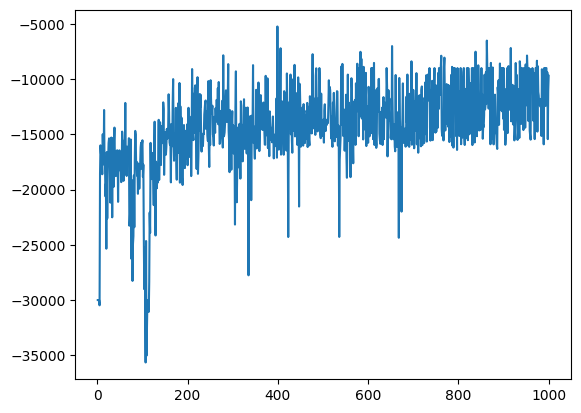

In [44]:
plt.plot(np.arange(1, 1001), total_reward_episode[:1000])
plt.show()

In [ ]:
state = env.reset()

In [68]:
for i in range(1):
    state, _, _, _, _ = env.step(env.action_space.sample())

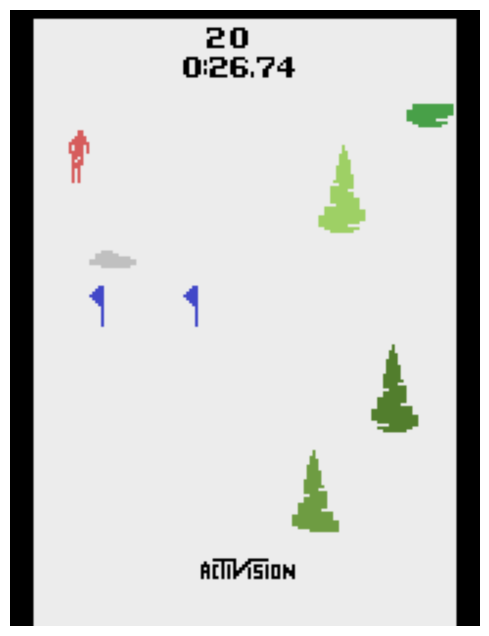

In [69]:

plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(state)

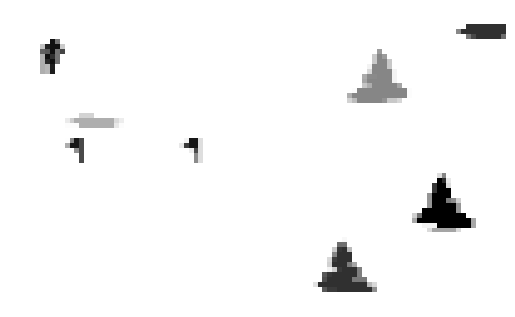

In [70]:
state = cv2.cvtColor(cv2.resize(state[24: -24:, 12: -12], (100, 60)), cv2.COLOR_BGR2GRAY)

plt.axis('off')
plt.imshow(state, 'grey')

## Точечная оценка J

In [41]:
mean_reward = np.mean(total_reward_episode[:1000])
mean_reward

-14211.015

## Интервальная оценка J

95.0% Confidence Interval: [-24240.25, -8746.400000000001]


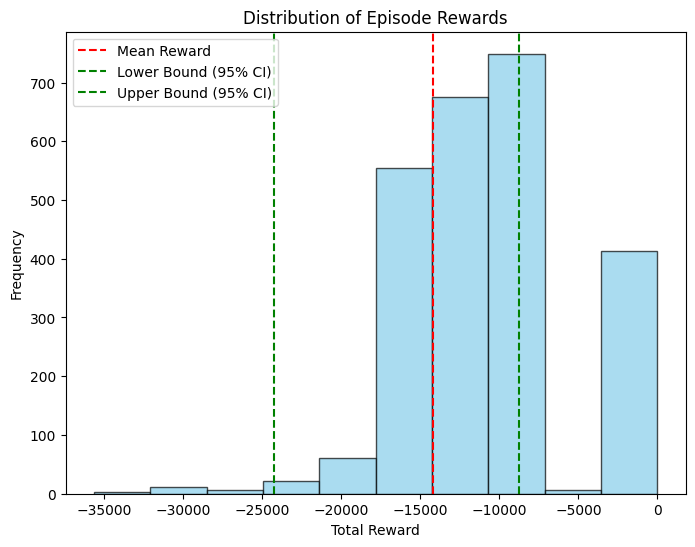

In [42]:
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

lower_bound = np.percentile(total_reward_episode[:1000], lower_percentile)
upper_bound = np.percentile(total_reward_episode[:1000], upper_percentile)

print(f"{confidence_level * 100}% Confidence Interval: [{lower_bound}, {upper_bound}]")

plt.figure(figsize=(8, 6))
plt.hist(total_reward_episode, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=mean_reward, color='red', linestyle='--', label='Mean Reward')
plt.axvline(x=lower_bound, color='green', linestyle='--', label='Lower Bound (95% CI)')
plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound (95% CI)')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Rewards')
plt.legend()
plt.show()

In [45]:
def plot(score, episodes):
  fig, ax = plt.subplots(figsize=(20, 10))

  x = np.asarray(range(episodes + 1))
  y = np.append(np.roll(score, 1), score[episodes - 1])

  ax.set_xlim(1, episodes)
  ax.plot(y, label='Score', color='#d4732f')

  mean = np.mean(score)
  ax.plot(np.asarray([mean for _ in x]), label='Mean={:.4f}'.format(mean))

  state_of_the_art = {
    'Human': -4336.9,
    'ASL DDQN': -8295,
    'DreamerV2': -9299,
    'Advantage Learning': -13264,
    'Rainbow': -28164,
    'Random': -17098.1
  }

  for whom, score in state_of_the_art.items():
      ax.plot(np.asarray([score for _ in range(episodes + 1)]), linestyle='--',
              label='{}={}'.format(whom, score))

  x_no_fill = x[1:]
  y_no_fill = y[1:]
  x_max, y_max = x_no_fill[np.argmax(y_no_fill)], y_no_fill.max()
  x_min, y_min = x_no_fill[np.argmin(y_no_fill)], y_no_fill.min()


  if x_max != x_min:
      max_marker = '*'
      max_color = '#f10202' 
      min_marker = 'X'
      min_color = '#161925'

      ax.scatter(x_max, y_max, label='Episode={}, Max={}'.format(x_max, y_max),
                  color=max_color, s=150, marker=max_marker)
      ax.scatter(x_min, y_min, label='Episode={}, Min={}'.format(x_min, y_min),
                  color=min_color, s=150, marker=min_marker)

  ax.set_title("Total Score vs Episodes", fontsize='x-large')
  ax.legend()
  ax.set_xlabel('Episode', fontsize='large')
  ax.set_ylabel("Score", fontsize='large')

  ax.legend(loc='lower right')

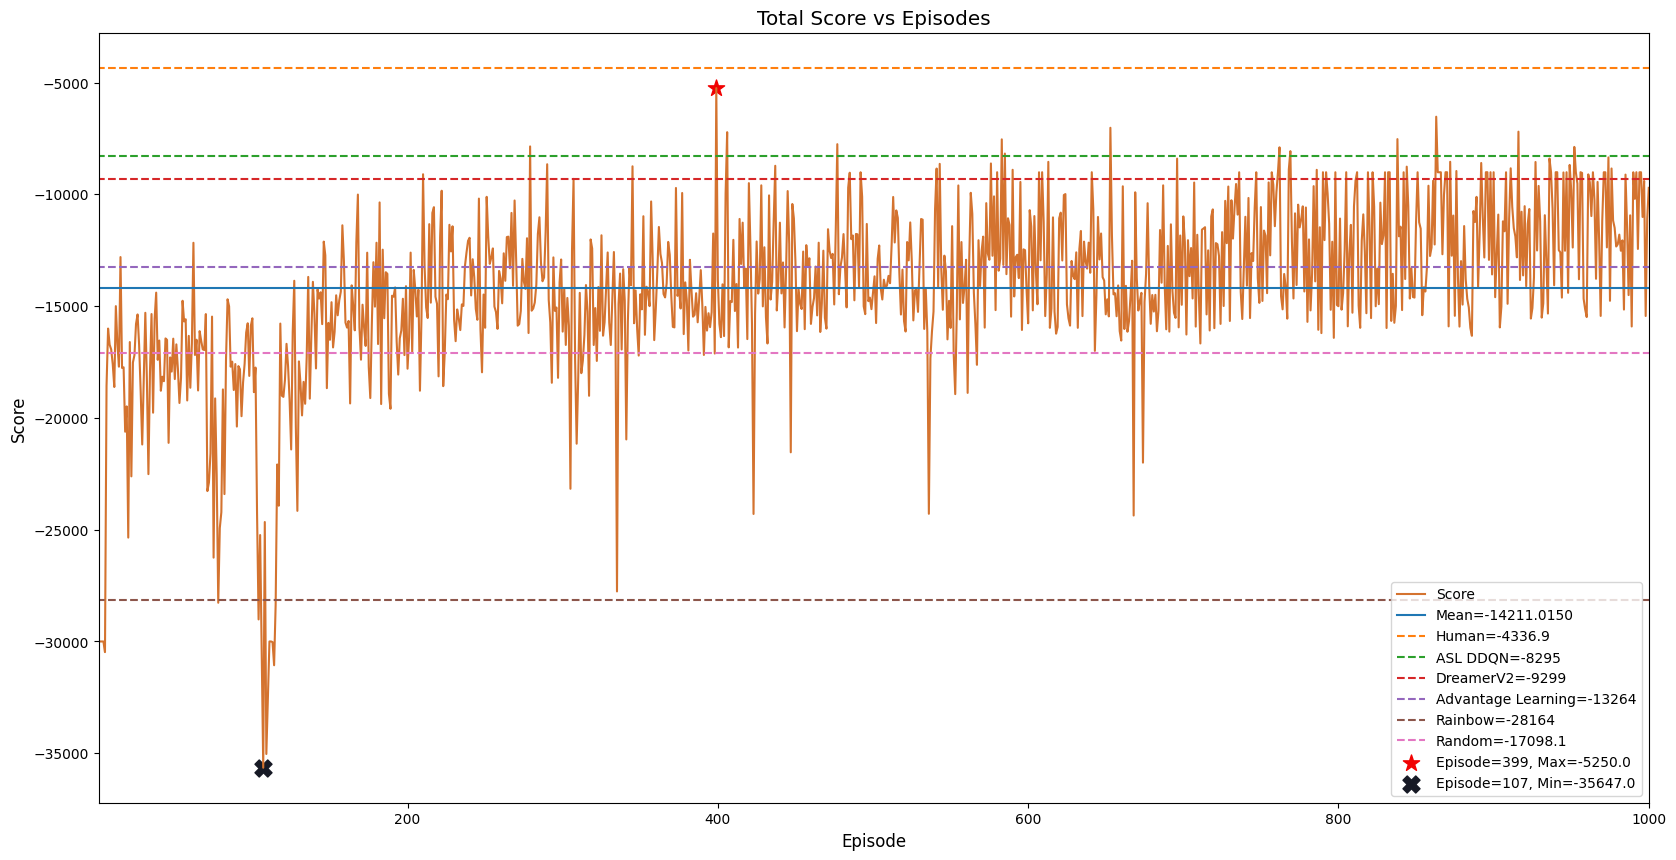

In [46]:
plot(total_reward_episode[:1000], 1000)